# Recovering Transfer Functions

In this notebook, we are interested in learning the mapping of an input function to an output function, otherwise known as a *transfer function*: 

![TransferFunction](images/transferFunction.png)

To illustrate how this can be done, we will be using a simple example of a transfer function over a linear pulse

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load data

In this initial dataset, we have an input signal and the corresponding output signal, given at certain timesteps. Based off this data, we want to learn what the transfer function is which maps the input signal to the output signal. First step is to load the data:

In [2]:
df = pd.read_csv("data/pulse_data/pulse_response_T5(in).csv")
df.head()

,time,input_signal,output_signal
0,0.0,0,0.0
1,0.1,0,0.0
2,0.2,0,0.0
3,0.3,0,0.0
4,0.4,0,0.0


Now, we can convert the pandas DataFrame into a Numpy Array and plot what the data actually looks like

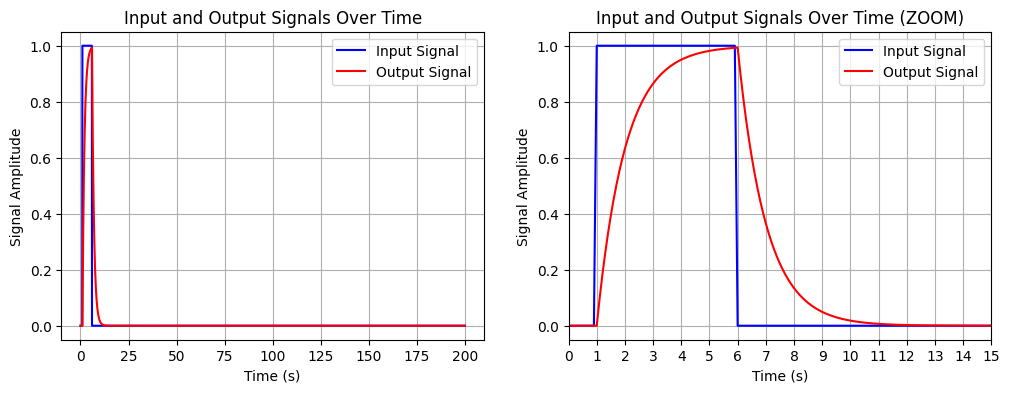

In [3]:
data = df.to_numpy()
time = data[:, 0]
input_signal = data[:, 1]
output_signal = data[:, 2]

fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].plot(time, input_signal, label='Input Signal', color='blue')
axes[0].plot(time, output_signal, label='Output Signal', color='red')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Signal Amplitude')
axes[0].set_title('Input and Output Signals Over Time')
axes[0].legend()
axes[0].grid()

axes[1].plot(time, input_signal, label='Input Signal', color='blue')
axes[1].plot(time, output_signal, label='Output Signal', color='red')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Signal Amplitude')
axes[1].set_title('Input and Output Signals Over Time (ZOOM)')
axes[1].legend()
axes[1].grid()
axes[1].set_xlim(0, 15)
axes[1].set_xticks(np.arange(0, 16, 1))

plt.show()

We see that the input signal is a linear pulse, which starts at an amplitude of 0, changes to an amplitude of 1 at time $t = 1$, last for 5 seconds, then goes back to an amplitude of 0. The total length of the data is from 0 to 200 seconds, as later one we will be dealing with signals that last much longer than 5 seconds.

The output signal takes some time to reach the same amplitude as the input signal, then slowly decays to 0. 

For *(I don't remember why)*, we will truncate the beginning of the signal so it starts at an amplitude of 1.

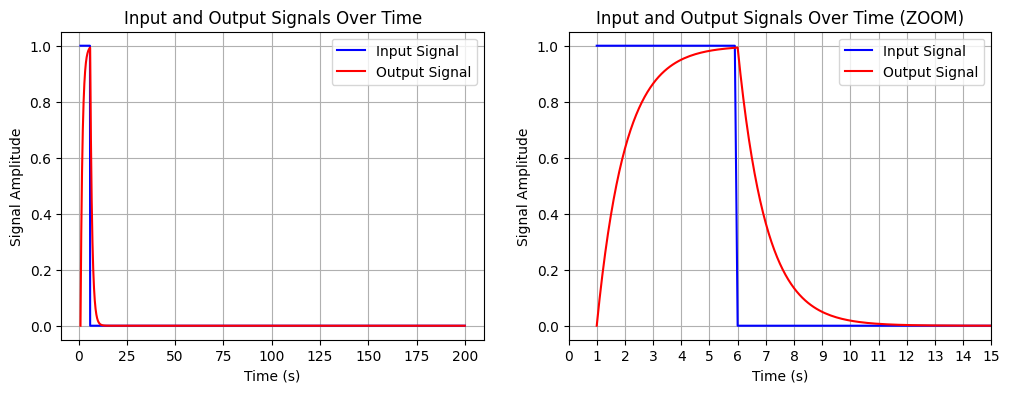

In [4]:
start = np.where(input_signal > 0)[0][0]
time = time[start:]
input_signal = input_signal[start:]
output_signal = output_signal[start:]
N = time.shape[0]
start_time = time[start]

fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].plot(time, input_signal, label='Input Signal', color='blue')
axes[0].plot(time, output_signal, label='Output Signal', color='red')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Signal Amplitude')
axes[0].set_title('Input and Output Signals Over Time')
axes[0].legend()
axes[0].grid()

axes[1].plot(time, input_signal, label='Input Signal', color='blue')
axes[1].plot(time, output_signal, label='Output Signal', color='red')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Signal Amplitude')
axes[1].set_title('Input and Output Signals Over Time (ZOOM)')
axes[1].legend()
axes[1].grid()
axes[1].set_xlim(0, 15)
axes[1].set_xticks(np.arange(0, 16, 1))

plt.show()

### Matrix Method

In essence, we want to solve a classic $Ax=b$ problem, where $x$ is the input signal and $b$ is the output signal. However, classicaly we would learn $x$, but in this situation the matrix $A$ which maps $x$ to $b$ is what interests us. Learning $A$ is a more complicated problem, so let's see if we can reformulate this in the form $Xa = b$:

$$
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{mn}
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{bmatrix}
=
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{n}
\end{bmatrix}
$$

We need to remember that we are learning a transfer function $H$ such that $(Hi)(t)=(o)$, which is a convolution:

$$(H \ast i)(t) = \int_{\tau_i}^{\tau_f} i(\tau)H(t - \tau)d\tau = o(t)$$

We can discretize this form:

$$(H \ast i)(t_d) = \sum_{\tau_i}^{\tau_f} i(\tau)H(t_d - \tau)d\tau = o(t_d)$$

However, $\tau-t$ in $H(\tau-t)$ must not be negative as the output of the signal should only be dependent on the previous values of the signal (not future ones nor values which haven't existed $t<0$), thus we can rewrite the transfer function as:

$$(H \ast i)(t_d) = \sum_{\tau_i}^{\tau_d} i(\tau)H(t_d - \tau)d\tau = o(t_d)$$

Let's write out the equations for different time steps:

$$
\begin{aligned}
o(t_1) &= i(t_0)H(0) \\
o(t_2) &= i(t_0)H(1) + i(t_1)H(0) \\
o(t_3) &= i(t_0)H(2) + i(t_1)H(1) + i(t_2)H(0) \\
\vdots\quad\; &\vdots \\
o(t_N) &= i(t_0)H(N-1) + i(t_1)H(N-2) + \cdots + i(t_{N-1})H(0)
\end{aligned}
$$

We are dealing with N values of $H$ and N values of $i$. We can represent this convolution as a matrix operation $Hi=0$:

$$
\begin{bmatrix}
H(0) & 0 & \cdots & 0 \\
H(1) & H(0) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
H(N-1) & H(N-2) & \cdots & H(0)
\end{bmatrix}
\begin{bmatrix}
i(t_0) \\
i(t_1) \\
\vdots \\
i(t_{N-1})
\end{bmatrix}
=
\begin{bmatrix}
o(1) \\
o(2) \\
\vdots \\
o(N)
\end{bmatrix}
$$

or as $Ih=o$:

$$
\begin{bmatrix}
i(0) & 0 & \cdots & 0 \\
i(1) & i(0) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
i(N-1) & i(N-2) & \cdots & i(0)
\end{bmatrix}
\begin{bmatrix}
H(t_0) \\
H(t_1) \\
\vdots \\
H(t_{N-1})
\end{bmatrix}
=
\begin{bmatrix}
o(1) \\
o(2) \\
\vdots \\
o(N)
\end{bmatrix}
$$

Now we just need to construct $I$:

In [5]:
I = np.zeros((N,N))

for i in range(N):
    for k in range(i+1):
        I[i, k] = input_signal[i-k]

I

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]], shape=(1991, 1991))

Solve for $h$ using a traditional numerical method (implemented using numpy):

In [6]:
h = np.linalg.solve(I, output_signal)

Finally, we reconstruct the matrix $H$ from $h$:

In [7]:
H = np.zeros((N,N))

for i in range(N):
    for k in range(i+1):
        H[i, k] = h[i-k]

We just need to make sure that the $H$ we found maps the input signal to the correct output signal

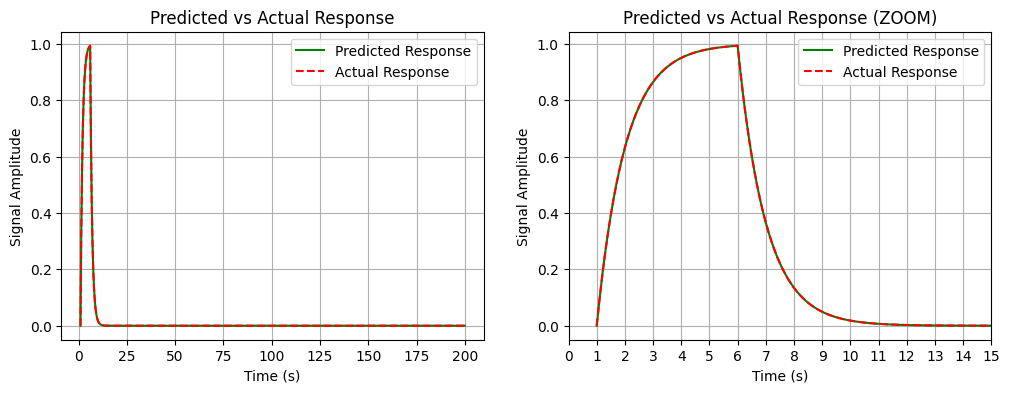

In [8]:
# Compute predicted response
pred_response = H @ input_signal.reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(time, pred_response, label='Predicted Response', color='green')
axes[0].plot(time, output_signal, label='Actual Response', color='red', linestyle='dashed')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Signal Amplitude')
axes[0].set_title('Predicted vs Actual Response')
axes[0].legend()
axes[0].grid()

axes[1].plot(time, pred_response, label='Predicted Response', color='green')
axes[1].plot(time, output_signal, label='Actual Response', color='red', linestyle='dashed')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Signal Amplitude')
axes[1].set_title('Predicted vs Actual Response (ZOOM)')
axes[1].legend()
axes[1].grid()
axes[1].set_xlim(0, 15)
axes[1].set_xticks(np.arange(0, 16, 1))

plt.show()


Voila, we match the output signal perfectly!

We know what the real analytic kernel is:

$$H(t-\tau) = e^{-|t - \tau|}$$

So let's compare the real and solved kernels:

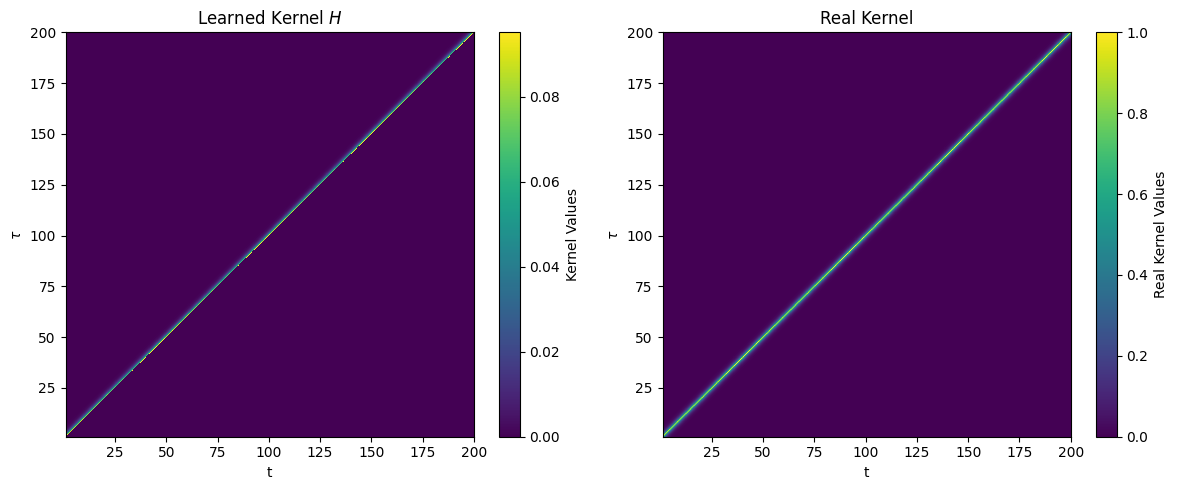

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

X, Y = np.meshgrid(time, time)
pcm1 = axes[0].pcolormesh(X, Y, H, shading='auto')
fig.colorbar(pcm1, ax=axes[0], label='Kernel Values')
axes[0].set_title('Learned Kernel $H$')
axes[0].set_xlabel('t')
axes[0].set_ylabel(r'$\tau$')

def real_kernel(t, tau):
    return np.exp(-np.abs(tau - t))

real = real_kernel(X, Y)
pcm2 = axes[1].pcolormesh(X, Y, real, shading='auto', cmap='viridis')
fig.colorbar(pcm2, ax=axes[1], label='Real Kernel Values')
axes[1].set_title('Real Kernel')
axes[1].set_xlabel('t')
axes[1].set_ylabel(r'$\tau$')

plt.tight_layout()
plt.show()


Both kernels resemble each other qualitatively, but we see that there is a difference in scaling.

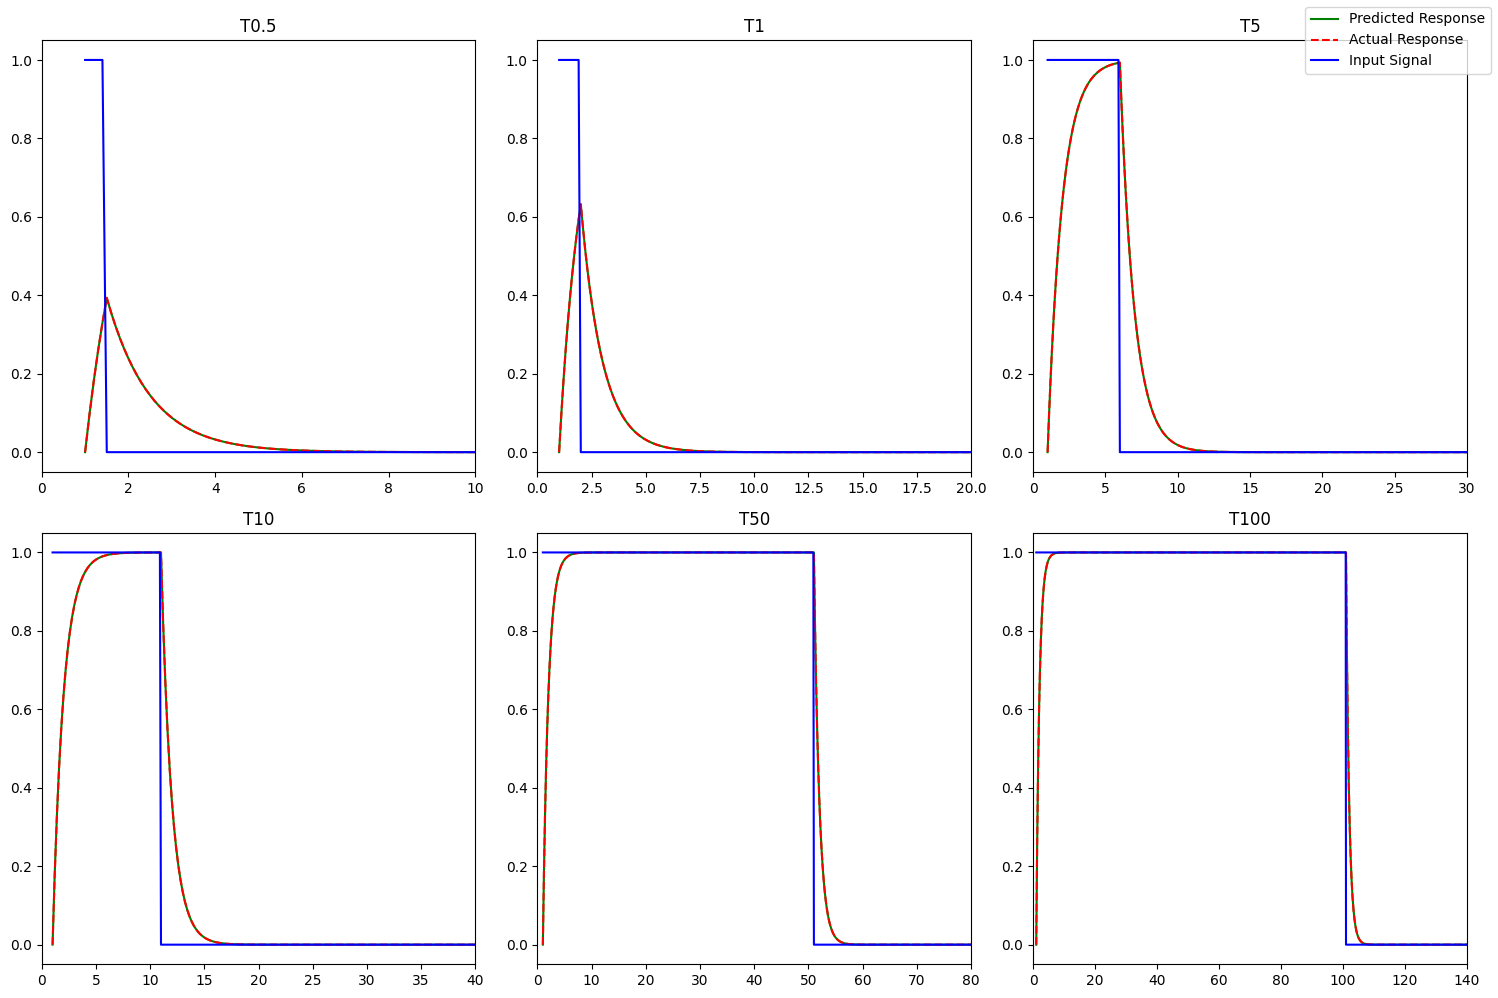

In [10]:
df05 = pd.read_csv("data/pulse_data/pulse_response_T0.csv").to_numpy()
df1 = pd.read_csv("data/pulse_data/pulse_response_T1(in).csv").to_numpy()
df5 = pd.read_csv("data/pulse_data/pulse_response_T5(in).csv").to_numpy()
df10 = pd.read_csv("data/pulse_data/pulse_response_T10(in).csv").to_numpy()
df50 = pd.read_csv("data/pulse_data/pulse_response_T50(in).csv").to_numpy()
df100 = pd.read_csv("data/pulse_data/pulse_response_T100(in).csv").to_numpy()

dfs = [df05, df1, df5, df10, df50, df100]
signal_names = ['T0.5', 'T1','T5', 'T10', 'T50', 'T100']
limits =  [10, 20, 30, 40, 80, 140]
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for i, df_ in enumerate(dfs):
    time_ = df_[:,0]
    input_signal_ = df_[:,1]
    output_signal_ = df_[:,2]

    pred = H @ input_signal_.reshape(-1, 1)[start:,:]

    axes[i].plot(time_[start:], pred, label='Predicted Response', color='green')
    axes[i].plot(time_[start:], output_signal_[start:], label='Actual Response', color='red', linestyle='dashed')
    axes[i].plot(time_[start:], input_signal_[start:], label='Input Signal', color='blue')

    axes[i].set_title(signal_names[i])
    axes[i].set_xlim(0, limits[i])

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

### Fourier Transform Method

In the previous section, we showed how to find H given the equation $H \ast i = o$. However, let's recall an important property of Fourier Transforms:

$$H \ast i = 0 \xrightarrow{\mathcal{F}} \hat{H} \hat{i} = \hat{o}$$

Thus, we can recover H in an alternative way:

$$
H = \mathcal{F}^{-1} \!\Biggl( \hat{H} \Biggr) = \mathcal{F}^{-1} \!\Biggl( \frac{\hat{o}}{\hat{i}} \Biggr)
$$


c:\Users\mathi\Desktop\Friction Project\NO_Tutorial\.venv\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mathi\Desktop\Friction Project\NO_Tutorial\.venv\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


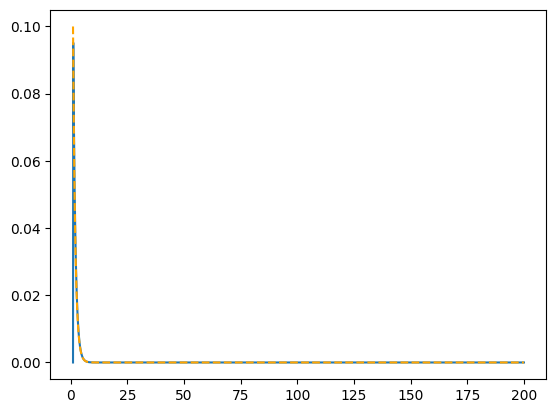

In [11]:
o_hat = np.fft.fft(output_signal)
i_hat = np.fft.fft(input_signal)
H_hat = o_hat / i_hat
H = np.fft.ifft(H_hat)

dt = 0.1 

plt.plot(time, H)
plt.plot(time, np.exp(-time+1) * dt, label='Exponential Decay', color='orange', linestyle='dashed')

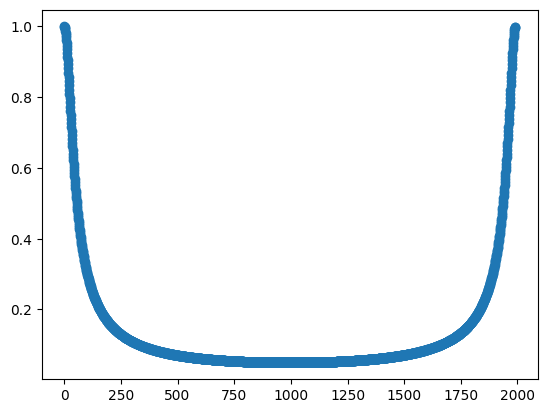

In [12]:
plt.scatter( [i for i in range(len(H_hat))],np.abs(H_hat))

In [ ]:
from ipywidgets import interact, IntSlider

# Define interactive function
def plot_with_frequencies(signals_kept):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Copy H_hat and zero out frequencies beyond signals_kept
    H_hat_ = H_hat.copy()
    H_hat_[signals_kept:2000-signals_kept] = 0

    for i, df_ in enumerate(dfs):
        time_ = df_[:, 0]
        input_signal_ = df_[:, 1]
        output_signal_ = df_[:, 2]

        input_signal_hat = np.fft.fft(input_signal_[start:])

        pred_hat = H_hat_ * input_signal_hat
        pred = np.fft.ifft(pred_hat)

        axes[i].plot(time_[start:], pred.real, label='Predicted Response', color='green')
        axes[i].plot(time_[start:], output_signal_[start:], label='Actual Response', color='red', linestyle='dashed')
        axes[i].plot(time_, input_signal_, label='Input Signal', color='blue')

        axes[i].set_title(signal_names[i])
        axes[i].set_xlim(-5, limits[i])

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

# Define slider widget for number of frequencies kept
slider = IntSlider(min=1, max=800, step=1, value=800, description='Frequencies Kept')

# Launch interactive plot
interact(plot_with_frequencies, signals_kept=slider)

interactive(children=(IntSlider(value=800, description='Frequencies Kept', max=800, min=1), Output()), _dom_cl…

<function __main__.plot_with_frequencies(signals_kept)>

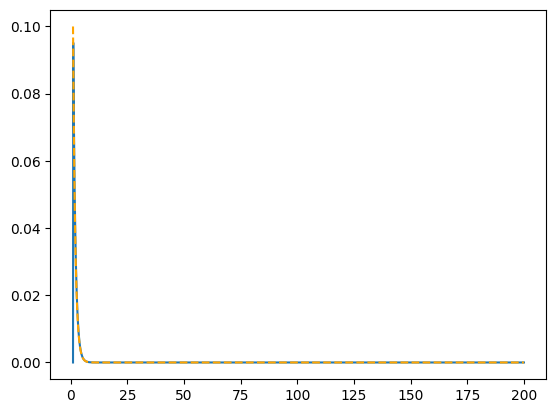

In [15]:
impulse = np.zeros(len(time))
impulse[0] = 1

impulse_response = np.fft.ifft(H_hat * np.fft.fft(impulse))
plt.plot(time, impulse_response)
plt.plot(time, np.exp(-time+1)*0.1, label='Exponential Decay', color='orange', linestyle='dashed')